In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = 8, 8
from IPython.display import Image
color = 'lightsteelblue'

In [5]:
import pymc3 as pm
import random
import numpy as np
from scipy.stats import beta, binom, bernoulli, poisson, norm, ttest_ind
import pandas as pd
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from collections import Counter
import theano.tensor as tt
import scipy.stats as stats
from scipy.integrate import quad
import itertools
import random

# Chapter 16: Metric-Predicted Variable on One or Two Groups

These GLMs focus on metric predicted variables using data from either one or two groups. 

## Estimating the Mean and Standard Deviation of a Normal Distribution

The normal distribution is given below:

$$ p(y \vert \mu, \sigma) = \frac{1}{Z} \text{exp}\Big(\frac{-(y-\mu)^2}{2\sigma^2}\Big) $$

The probability of a single point $y$ is $p(y \vert \mu, \sigma)$ while the probability of a set of independent points D is $\Pi_i p(y_i \vert \mu,\sigma)$. Bayes rule can be used to allocate credibility to the parameters $\mu$ and $\sigma$ to maximize the probabilities of the data points in the set D.

$$ p(\mu,\sigma \vert D) = \frac{p(D \vert \mu, \sigma)p(\mu,\sigma)}{\int \int p(D \vert \mu, \sigma)p(\mu,\sigma) d\mu d\sigma}  $$

Assuming three data points, D = {85,100,115}, probability distribution with sample parameter values are shown below.

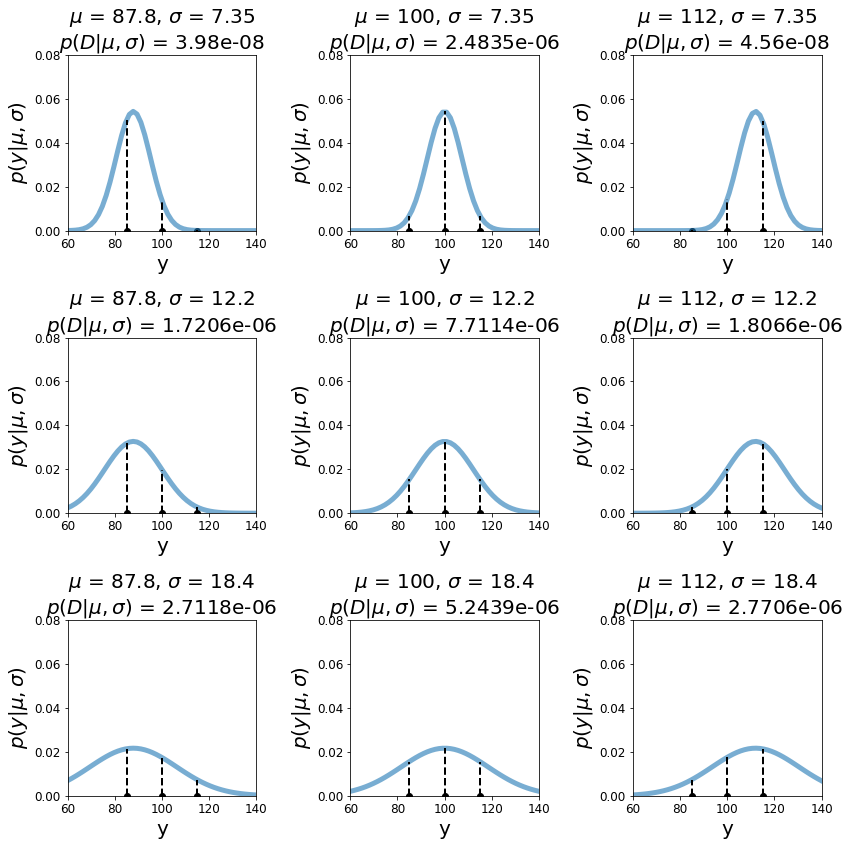

In [6]:
mus = [87.8,100,112]
sigmas = [7.35, 12.2,18.4]
D = [85,100,115]
x = np.linspace(60,140)
text_x = [-50,65,115]

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

i = 0
j = 0

for plot in range(9):
    ax = plt.subplot(gs[i,j])
    ax.plot(x, norm.pdf(x, loc = mus[j], scale = sigmas[i]),'-', lw=5, alpha=0.6)
    
    D_norm = [norm.pdf(x, loc = mus[j], scale = sigmas[i]) for x in D]
    ax.set_xlim(60,140)
    ax.set_ylim(0,0.08)
    ax.set_xlabel('y')
    ax.set_ylabel(r'$p(y \vert \mu, \sigma)$')
    ax.set_title(r'$\mu$ = ' + str(mus[j]) + r', $\sigma$ = ' + str(sigmas[i]) + '\n' +
                r'$p(D \vert \mu, \sigma)$ = ' + str(round(np.prod(D_norm),10)))
        
    for num in range(len(D)):
        ax.scatter(D[num],0, marker='o', color='k')
        ax.axvline(D[num],ymin = 0, ymax = D_norm[num]/0.08,color='k', linestyle='--')
        
    j += 1
    if j == 3:
        i += 1
        j = 0
    

plt.tight_layout()
plt.show()     

Solving for the best estimate of the mean and standard deviation can be done using MCMC approximation. Below is an example using the Smart Drug group from the IQ dataset.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


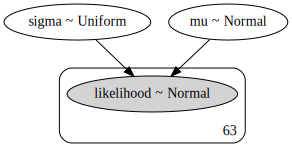

In [30]:
IQ = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
drug = IQ[IQ.Group == 'Smart Drug'].Score
mean = np.mean(drug)
sd = np.std(drug)
with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mean, sd)
    sigma = pm.Uniform('sigma', sd/1000, sd*1000)
    
    # Likelihood function
    likelihood = pm.Normal('likelihood', mu, sd=sigma, observed=drug)
    
    trace_normal = pm.sample(1500, tune=150, burn=20, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})
    
    
pm.model_to_graphviz(model)


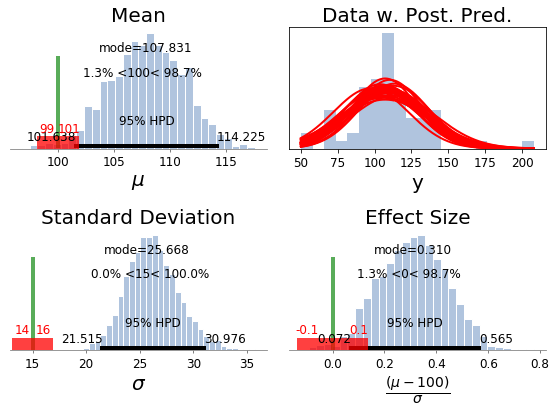

In [8]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_normal['mu'], ax=ax0, color=color, rope = [99,101], ref_val = 100, point_estimate = 'mode')
ax0.set_title('Mean')
ax0.set_xlabel(r'$\mu$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_normal['sigma'], ax=ax1, color=color, rope = [14,16], ref_val = 15, point_estimate = 'mode')
ax1.set_title('Standard Deviation')
ax1.set_xlabel(r'$\sigma$')

ax2 = plt.subplot(gs[1,1])
pm.plot_posterior((trace_normal['mu'] - 100)/trace_normal['sigma'], ax=ax2, color=color, rope = [-0.1,0.1], ref_val = 0, point_estimate = 'mode')
ax2.set_title('Effect Size')
ax2.set_xlabel(r'$\frac{(\mu-100)}{\sigma}$')

curve_samples = 30
indexes = np.random.choice(range(len(trace_normal)), replace = False, size = curve_samples)
ax3 = plt.subplot(gs[0,1])
ax3.hist(drug, bins=20, density = True, color = color)
x = np.linspace(min(drug), max(drug),1000)
for step in indexes:
    ax3.plot(x, norm.pdf(x, trace_normal['mu'][step], trace_normal['sigma'][step]), c='r')
ax3.set_title('Data w. Post. Pred.')
ax3.set_xlabel('y')
ax3.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Outliers and Robust Estimation: The t distribution

t distributions are more useful when working with normal-like distributions but with taller or heavier tails. This is controlled by the parameter, $\nu$, also known as the degrees of freedom or as normality. As $\nu$ approaches infinity, the distribution becomes normal. The scale parameter in this case is not the standard deviation. 

The t distribution is just one example of a distribution that can be used to account for noise. In general, a proper distribution should be found for each situation. Using heavy tailed distributions is known as robust estimation because the central tendency is robust to extreme outliers while still accounting for them

We again solve for the best estimates of the parameters of the distribution using the Smart Drug group from the IQ dataset.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


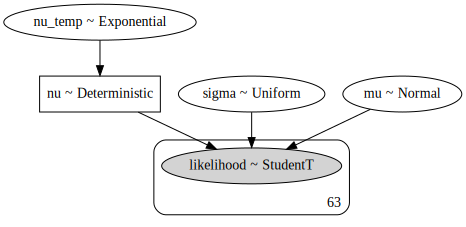

In [31]:
IQ = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
drug = IQ[IQ.Group == 'Smart Drug'].Score
mean = np.mean(drug)
sd = np.std(drug)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mean, sd)
    sigma = pm.Uniform('sigma', sd/1000, sd*1000)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
    likelihood = pm.StudentT('likelihood', mu = mu, sd=sigma, nu = nu, observed=drug)
    
    trace_t = pm.sample(1500, tune=150, burn=20, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})
    
pm.model_to_graphviz(model)


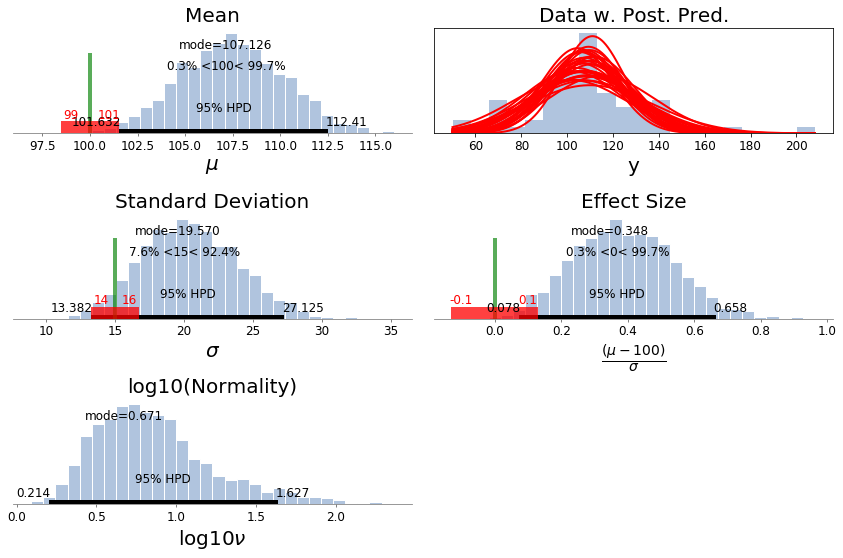

In [10]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_t['mu'], ax=ax0, color=color, rope = [99,101], ref_val = 100, point_estimate = 'mode')
ax0.set_title('Mean')
ax0.set_xlabel(r'$\mu$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_t['sigma'], ax=ax1, color=color, rope = [14,16], ref_val = 15, point_estimate = 'mode')
ax1.set_title('Standard Deviation')
ax1.set_xlabel(r'$\sigma$')

ax2 = plt.subplot(gs[1,1])
pm.plot_posterior((trace_t['mu'] - 100)/trace_t['sigma'], ax=ax2, color=color, rope = [-0.1,0.1], ref_val = 0, point_estimate = 'mode')
ax2.set_title('Effect Size')
ax2.set_xlabel(r'$\frac{(\mu-100)}{\sigma}$')


curve_samples = 30
indexes = np.random.choice(range(len(trace_t)), replace = False, size = curve_samples)
ax3 = plt.subplot(gs[0,1])
ax3.hist(drug, bins=20, density = True, color = color)
x = np.linspace(min(drug), max(drug),1000)
for step in indexes:
    ax3.plot(x, norm.pdf(x, trace_t['mu'][step], trace_t['sigma'][step]), c='r')
ax3.set_title('Data w. Post. Pred.')
ax3.set_xlabel('y')
ax3.yaxis.set_visible(False)

ax4 = plt.subplot(gs[2,0])
pm.plot_posterior(np.log10(trace_t['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

plt.tight_layout()
plt.show()

Notice how the distribution accounts more for the outlier data.

## 2 Groups

It doesn't make sense to compare the Smart Drug group to an arbitrary mean of 100. Instead, using two groups, the Smart Drug group can be compared to a Placebo group. When using NHST, we get the below results. Because the p value is great than 0.05, we fail to reject the null hypothesis that the means of both groups are the same.

When using Bayesian analysis with a reasonable ROPE, we would judge that there is a difference between the groups, thus contradicting the NHST results. 

In [11]:
drug = IQ[IQ.Group == 'Smart Drug'].Score
placebo = IQ[IQ.Group == 'Placebo'].Score

ttest_ind(drug,placebo)

Ttest_indResult(statistic=1.9248842176649301, pvalue=0.05665101426276756)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


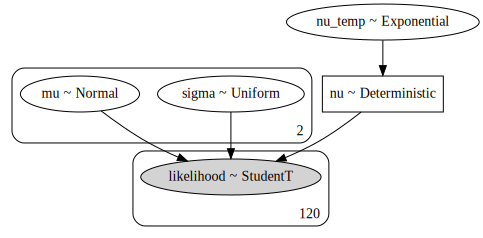

In [32]:
IQ = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
trial_type = IQ.Group.cat.codes.values
trials = IQ.Group.cat.categories
num_of_trials = len(trials)
observed = IQ.Score

mean = np.mean(IQ.Score)
sd = np.std(IQ.Score)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mu = mean, sd = sd, shape = num_of_trials)
    sigma = pm.Uniform('sigma', lower = sd/1000, upper = sd*1000, shape = num_of_trials)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
    likelihood = pm.StudentT('likelihood', mu = mu[trial_type], sd=sigma[trial_type], nu = nu, observed=observed)
    
    trace_two = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})
    
pm.model_to_graphviz(model)

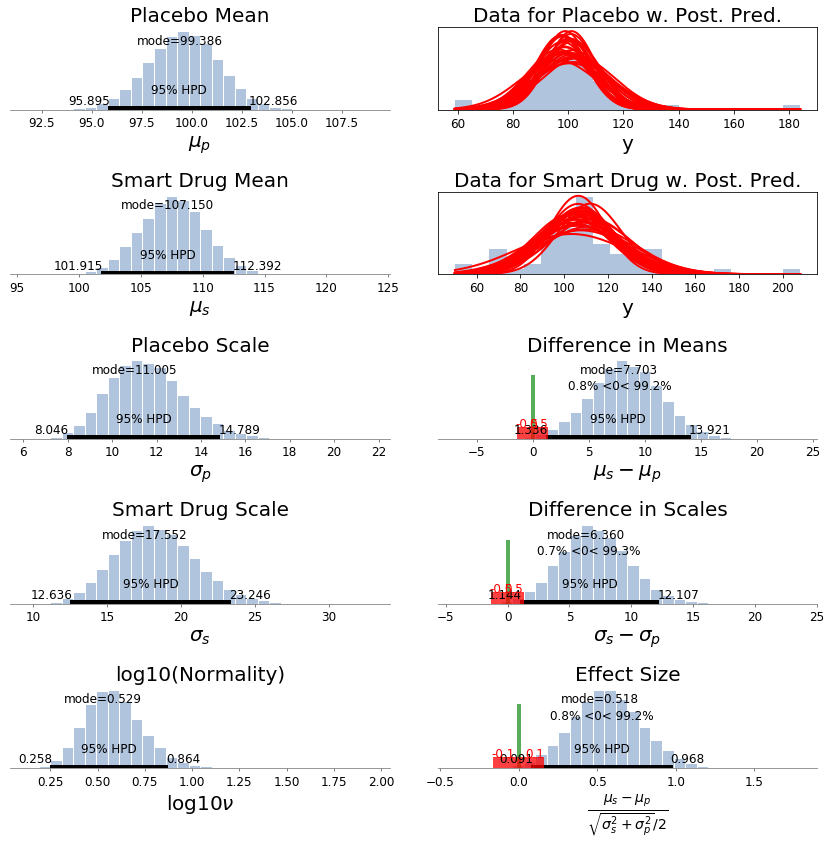

In [13]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_two['mu'][:,0], ax=ax0, color=color, point_estimate = 'mode')
ax0.set_title('Placebo Mean')
ax0.set_xlabel(r'$\mu_p$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_two['mu'][:,1], ax=ax1, color=color, point_estimate = 'mode')
ax1.set_title('Smart Drug Mean')
ax1.set_xlabel(r'$\mu_s$')

ax2 = plt.subplot(gs[2,0])
pm.plot_posterior(trace_two['sigma'][:,0], ax=ax2, color=color, point_estimate = 'mode')
ax2.set_title('Placebo Scale')
ax2.set_xlabel(r'$\sigma_p$')

ax3 = plt.subplot(gs[3,0])
pm.plot_posterior(trace_two['sigma'][:,1], ax=ax3, color=color, point_estimate = 'mode')
ax3.set_title('Smart Drug Scale')
ax3.set_xlabel(r'$\sigma_s$')

ax4 = plt.subplot(gs[4,0])
pm.plot_posterior(np.log10(trace_two['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

curve_samples = 30
placebo = IQ[IQ.Group == 'Placebo'].Score
drug = IQ[IQ.Group == 'Smart Drug'].Score
indexes = np.random.choice(range(len(trace_two)), replace = False, size = curve_samples)

ax5 = plt.subplot(gs[0,1])
ax5.hist(placebo, bins=20, density = True, color = color)
x = np.linspace(min(placebo), max(placebo),1000)
for step in indexes:
    ax5.plot(x, norm.pdf(x, trace_two['mu'][:,0][step], trace_two['sigma'][:,0][step]), c='r')
ax5.set_title('Data for Placebo w. Post. Pred.')
ax5.set_xlabel('y')
ax5.yaxis.set_visible(False)

ax6 = plt.subplot(gs[1,1])
ax6.hist(drug, bins=20, density = True, color = color)
x = np.linspace(min(drug), max(drug),1000)
for step in indexes:
    ax6.plot(x, norm.pdf(x, trace_two['mu'][:,1][step], trace_two['sigma'][:,1][step]), c='r')
ax6.set_title('Data for Smart Drug w. Post. Pred.')
ax6.set_xlabel('y')
ax6.yaxis.set_visible(False)

ax7 = plt.subplot(gs[2,1])
pm.plot_posterior(trace_two['mu'][:,1] - trace_two['mu'][:,0], ax=ax7, color=color, ref_val = 0, rope=[-0.5,0.5], point_estimate = 'mode')
ax7.set_title('Difference in Means')
ax7.set_xlabel(r'$\mu_s - \mu_p$')

ax8 = plt.subplot(gs[3,1])
pm.plot_posterior(trace_two['sigma'][:,1] - trace_two['sigma'][:,0], ax=ax8, color=color, ref_val = 0, rope=[-0.5,0.5], point_estimate = 'mode')
ax8.set_title('Difference in Scales')
ax8.set_xlabel(r'$\sigma_s - \sigma_p$')

ax9 = plt.subplot(gs[4,1])
num = trace_two['mu'][:,1] - trace_two['mu'][:,0]
denom = ((trace_two['sigma'][:,1]**2 + trace_two['sigma'][:,0]**2)/2)**0.5
pm.plot_posterior(num/denom, ax=ax9, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax9.set_title('Effect Size')
ax9.set_xlabel(r'$\frac{\mu_s-\mu_p}{\sqrt{\sigma_s^2 + \sigma_p^2}/2}$')

plt.tight_layout()
plt.show()

# Chapter 16: Exercises

## 16.1
Shohat-Ophir et al. (2012) were interested in alcohol preferences of sexually deprived males. The procedure is illustrated in Figure 16.13, and was described as follows: “One cohort, rejected-isolated, was subjected to courtship conditioning; they experienced 1-h sessions of sexual rejection by mated females, three times a day, for 4 days. ...Flies in the mated-grouped cohort experienced 6-h sessions of mating with multiple receptive virgin females (ratio 1:5) for 4 days. Flies from each cohort were then tested in a two-choice preference assay, in which they voluntarily choose to consume food with or without 15% ethanol supplementation. (Shohat-Ophir et al., 2012, p. 1351, citations and  gure reference removed)” For each  y, the amount of each type of food consumed was converted to a preference ratio: the amount of ethanol-supplemented food minus the amount of regular food divided by the total of both. I constructed 3-day summary preference scores for each individual fruit  y by summing the consumption of ethanol and non-ethanol across days 6–8. The amounts of food consumed and the preference ratios are in the data file named ShohatOphirKAMH2012dataReduced.csv.

A. Run Jags-Ymet-Xnom2grp-MrobustHet-Example.R on the preference scores. Make sure that the ROPE on the means and standard deviation is scaled appropriately to the data. How big are differences between groups relative to the uncertainty of the estimate? What do you conclude?

Answer: 

The mode of the differences in the means is about 0.3. The HDI includes all positive values and doesn't include the ROPE. Also, the effect size, with a mode of 1.239, is relatively high. Thus, flies in the rejected-isolated cohort preferred more alcohol than the mated-grouped cohort.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


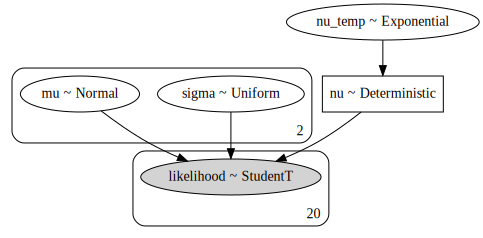

In [33]:
flies = pd.read_csv('data/ShohatOphirKAMH2012dataReduced.csv', dtype={'Group':'category'})
trial_type = flies.Group.cat.codes.values
trials = flies.Group.cat.categories
num_of_trials = len(trials)
observed = flies.PreferenceIndex

mean = np.mean(flies.PreferenceIndex)
sd = np.std(flies.PreferenceIndex)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mu = mean, sd = sd, shape = num_of_trials)
    sigma = pm.Uniform('sigma', lower = sd/1000, upper = sd*1000, shape = num_of_trials)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
    likelihood = pm.StudentT('likelihood', mu = mu[trial_type], sd=sigma[trial_type], nu = nu, observed=observed)
    
    trace_flies = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})
    
pm.model_to_graphviz(model)


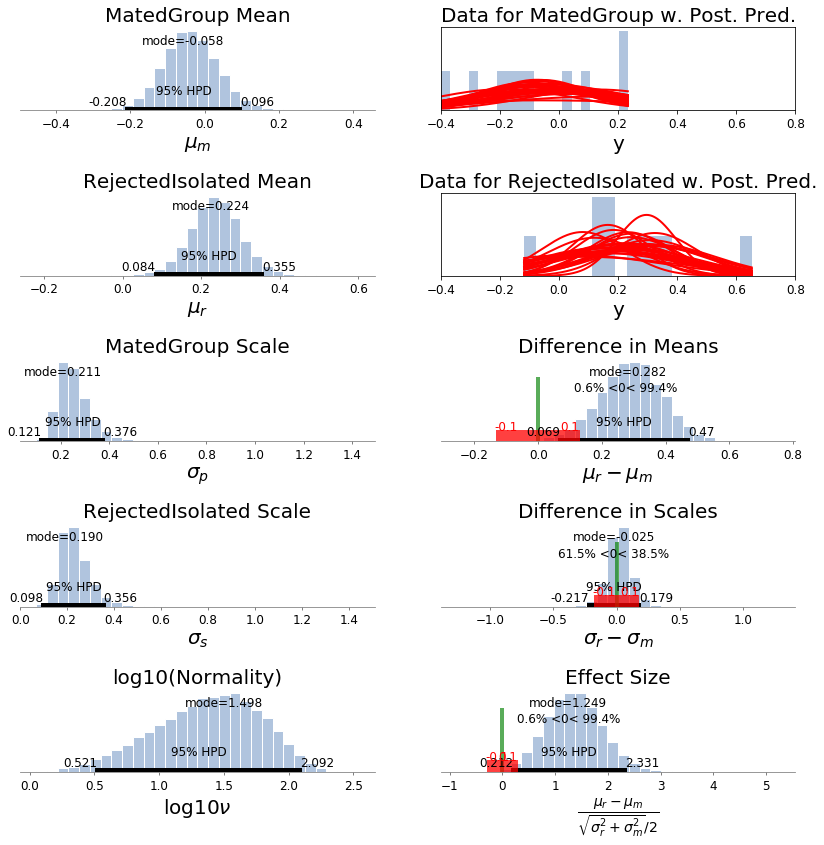

In [15]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_flies['mu'][:,0], ax=ax0, color=color, point_estimate = 'mode')
ax0.set_title('MatedGroup Mean')
ax0.set_xlabel(r'$\mu_m$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_flies['mu'][:,1], ax=ax1, color=color, point_estimate = 'mode')
ax1.set_title('RejectedIsolated Mean')
ax1.set_xlabel(r'$\mu_r$')

ax2 = plt.subplot(gs[2,0])
pm.plot_posterior(trace_flies['sigma'][:,0], ax=ax2, color=color, point_estimate = 'mode')
ax2.set_title('MatedGroup Scale')
ax2.set_xlabel(r'$\sigma_p$')

ax3 = plt.subplot(gs[3,0])
pm.plot_posterior(trace_flies['sigma'][:,1], ax=ax3, color=color, point_estimate = 'mode')
ax3.set_title('RejectedIsolated Scale')
ax3.set_xlabel(r'$\sigma_s$')

ax4 = plt.subplot(gs[4,0])
pm.plot_posterior(np.log10(trace_flies['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

curve_samples = 30
mated = flies[flies.Group == 'MatedGrouped'].PreferenceIndex
rejected = flies[flies.Group == 'RejectedIsolated'].PreferenceIndex
indexes = np.random.choice(range(len(trace_flies)), replace = False, size = curve_samples)

ax5 = plt.subplot(gs[0,1])
ax5.hist(mated, bins=20, density = True, color = color)
x = np.linspace(min(mated), max(mated),1000)
for step in indexes:
    ax5.plot(x, norm.pdf(x, trace_flies['mu'][:,0][step], trace_flies['sigma'][:,0][step]), c='r')
ax5.set_title('Data for MatedGroup w. Post. Pred.')
ax5.set_xlabel('y')
ax5.set_xlim(-0.4,0.8)
ax5.yaxis.set_visible(False)

ax6 = plt.subplot(gs[1,1])
ax6.hist(rejected, bins=20, density = True, color = color)
x = np.linspace(min(rejected), max(rejected),1000)
for step in indexes:
    ax6.plot(x, norm.pdf(x, trace_flies['mu'][:,1][step], trace_flies['sigma'][:,1][step]), c='r')
ax6.set_title('Data for RejectedIsolated w. Post. Pred.')
ax6.set_xlabel('y')
ax6.set_xlim(-0.4,0.8)
ax6.yaxis.set_visible(False)

ax7 = plt.subplot(gs[2,1])
pm.plot_posterior(trace_flies['mu'][:,1] - trace_flies['mu'][:,0], ax=ax7, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax7.set_title('Difference in Means')
ax7.set_xlabel(r'$\mu_r - \mu_m$')

ax8 = plt.subplot(gs[3,1])
pm.plot_posterior(trace_flies['sigma'][:,1] - trace_flies['sigma'][:,0], ax=ax8, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax8.set_title('Difference in Scales')
ax8.set_xlabel(r'$\sigma_r - \sigma_m$')

ax9 = plt.subplot(gs[4,1])
num = trace_flies['mu'][:,1] - trace_flies['mu'][:,0]
denom = ((trace_flies['sigma'][:,1]**2 + trace_flies['sigma'][:,0]**2)/2)**0.5
pm.plot_posterior(num/denom, ax=ax9, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax9.set_title('Effect Size')
ax9.set_xlabel(r'$\frac{\mu_r-\mu_m}{\sqrt{\sigma_r^2 + \sigma_m^2}/2}$')

plt.tight_layout()
plt.show()

B. Instead of focusing on the relative amounts of ethanol and regular food consumed, we might also be interested in the absolute total amount of food consumed. Run the analysis on the total consumption data, which has column name GrandTotal in the data  le. What do you conclude? In particular, would you want to make an argument to accept the null hypothesis of no difference? (Review Section 12.1.1, beginning on p. 336.)

Answer:

Using the GrandTotal, the HDI includes zero and includes the ROPE. In this case, we would not reject the fact that the means have a difference of zero. On the other hand, the effect size is very small (0.09), so it is difficult to accept the fact also.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


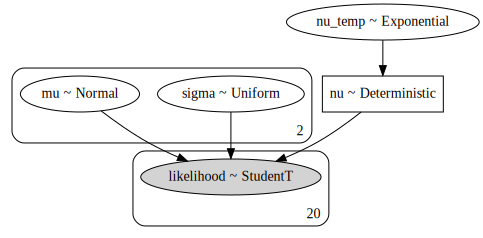

In [34]:
fliesflies = pd.read_csv('data/ShohatOphirKAMH2012dataReduced.csv', dtype={'Group':'category'})
trial_type = flies.Group.cat.codes.values
trials = flies.Group.cat.categories
num_of_trials = len(trials)
observed = flies.GrandTotal

mean = np.mean(flies.GrandTotal)
sd = np.std(flies.GrandTotal)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mu = mean, sd = sd, shape = num_of_trials)
    sigma = pm.Uniform('sigma', lower = sd/1000, upper = sd*1000, shape = num_of_trials)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
    likelihood = pm.StudentT('likelihood', mu = mu[trial_type], sd=sigma[trial_type], nu = nu, observed=observed)
    
    trace_flies = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})

pm.model_to_graphviz(model)


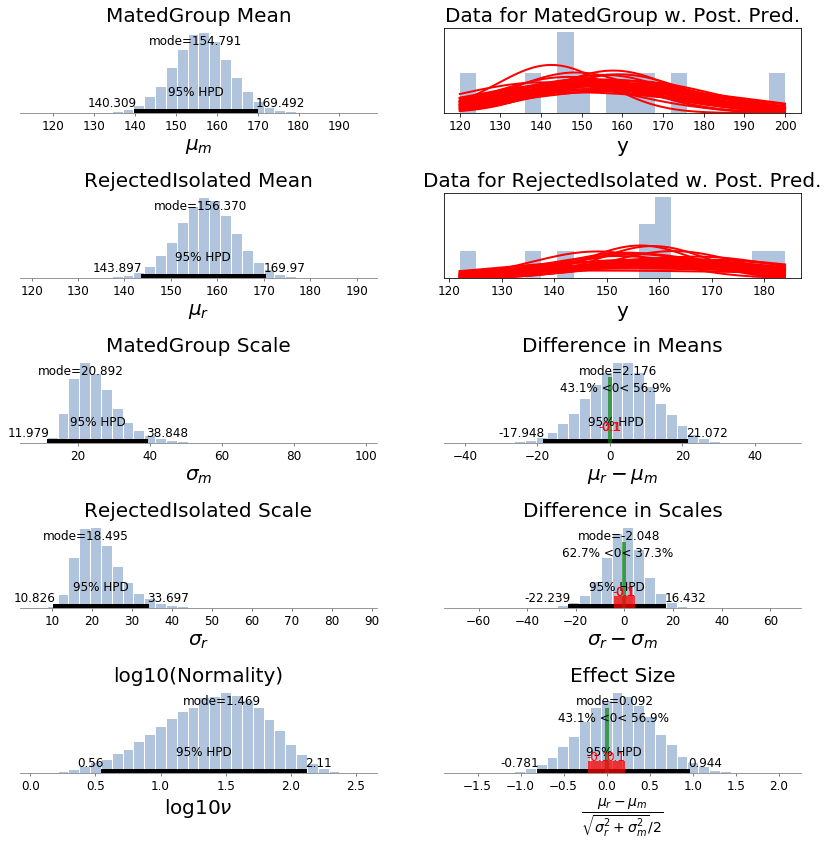

In [17]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_flies['mu'][:,0], ax=ax0, color=color, point_estimate = 'mode')
ax0.set_title('MatedGroup Mean')
ax0.set_xlabel(r'$\mu_m$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_flies['mu'][:,1], ax=ax1, color=color, point_estimate = 'mode')
ax1.set_title('RejectedIsolated Mean')
ax1.set_xlabel(r'$\mu_r$')

ax2 = plt.subplot(gs[2,0])
pm.plot_posterior(trace_flies['sigma'][:,0], ax=ax2, color=color, point_estimate = 'mode')
ax2.set_title('MatedGroup Scale')
ax2.set_xlabel(r'$\sigma_m$')

ax3 = plt.subplot(gs[3,0])
pm.plot_posterior(trace_flies['sigma'][:,1], ax=ax3, color=color, point_estimate = 'mode')
ax3.set_title('RejectedIsolated Scale')
ax3.set_xlabel(r'$\sigma_r$')

ax4 = plt.subplot(gs[4,0])
pm.plot_posterior(np.log10(trace_flies['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

curve_samples = 30
mated = flies[flies.Group == 'MatedGrouped'].GrandTotal
rejected = flies[flies.Group == 'RejectedIsolated'].GrandTotal
indexes = np.random.choice(range(len(trace_flies)), replace = False, size = curve_samples)

ax5 = plt.subplot(gs[0,1])
ax5.hist(mated, bins=20, density = True, color = color)
x = np.linspace(min(mated), max(mated),1000)
for step in indexes:
    ax5.plot(x, norm.pdf(x, trace_flies['mu'][:,0][step], trace_flies['sigma'][:,0][step]), c='r')
ax5.set_title('Data for MatedGroup w. Post. Pred.')
ax5.set_xlabel('y')
ax5.yaxis.set_visible(False)

ax6 = plt.subplot(gs[1,1])
ax6.hist(rejected, bins=20, density = True, color = color)
x = np.linspace(min(rejected), max(rejected),1000)
for step in indexes:
    ax6.plot(x, norm.pdf(x, trace_flies['mu'][:,1][step], trace_flies['sigma'][:,1][step]), c='r')
ax6.set_title('Data for RejectedIsolated w. Post. Pred.')
ax6.set_xlabel('y')
ax6.yaxis.set_visible(False)

ax7 = plt.subplot(gs[2,1])
pm.plot_posterior(trace_flies['mu'][:,1] - trace_flies['mu'][:,0], ax=ax7, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax7.set_title('Difference in Means')
ax7.set_xlabel(r'$\mu_r - \mu_m$')

ax8 = plt.subplot(gs[3,1])
pm.plot_posterior(trace_flies['sigma'][:,1] - trace_flies['sigma'][:,0], ax=ax8, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax8.set_title('Difference in Scales')
ax8.set_xlabel(r'$\sigma_r - \sigma_m$')

ax9 = plt.subplot(gs[4,1])
num = trace_flies['mu'][:,1] - trace_flies['mu'][:,0]
denom = ((trace_flies['sigma'][:,1]**2 + trace_flies['sigma'][:,0]**2)/2)**0.5
pm.plot_posterior(num/denom, ax=ax9, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax9.set_title('Effect Size')
ax9.set_xlabel(r'$\frac{\mu_r-\mu_m}{\sqrt{\sigma_r^2 + \sigma_m^2}/2}$')

plt.tight_layout()
plt.show()

## 16.2

The typical lifespan of a laboratory rat that eats ad lib is approximately 700 days. When rats are placed on a restricted diet, their longevity can increase, but there is a lot of variability in lifespans across di erent individual rats. Restricting the diet might not only a ect the typical lifespan, but restricting the diet might also a ect the variance of the lifespan across rats. We consider data fromR. L. Berger et al. (1988), as reported in Hand, Daly, Lunn, McConway, and Ostrowski (1994, data set #242), and which are available in the  le named RatLives.csv.

A. Run the two-group analysis on the rat longevity data. Use JAGS or Stan as you prefer (report which one you used). Report the code you used to read in the data  le, specify the column names for the data, and the ROPEs appropriate to the scale of the data. Do the groups appear to differ in their central tendencies and variances? Does the value of the normality parameter suggest that the data have outliers relative to a normal distribution? Do the groups appear to differ in their central tendencies and variances on the days-squared scale?

Answer:

With such a large effect size, the groups appear to differ in their mean and variance. The normality parameter is very small (less than 1), thus the distributions must be very heavy-tailed.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


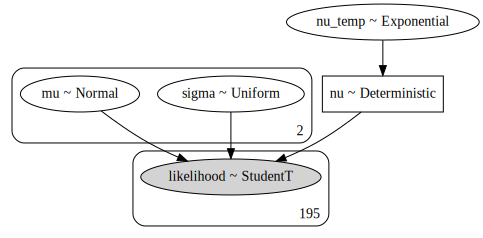

In [35]:
rats = pd.read_csv('data/RatLives.csv', dtype={'Group':'category'})
trial_type = rats.Group.cat.codes.values
trials = rats.Group.cat.categories
num_of_trials = len(trials)
observed = rats.DaysLive

mean = np.mean(rats.DaysLive)
sd = np.std(rats.DaysLive)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mu = mean, sd = sd, shape = num_of_trials)
    sigma = pm.Uniform('sigma', lower = sd/1000, upper = sd*1000, shape = num_of_trials)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
    likelihood = pm.StudentT('likelihood', mu = mu[trial_type], sd=sigma[trial_type], nu = nu, observed=observed)
    
    trace_rats = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})

pm.model_to_graphviz(model)


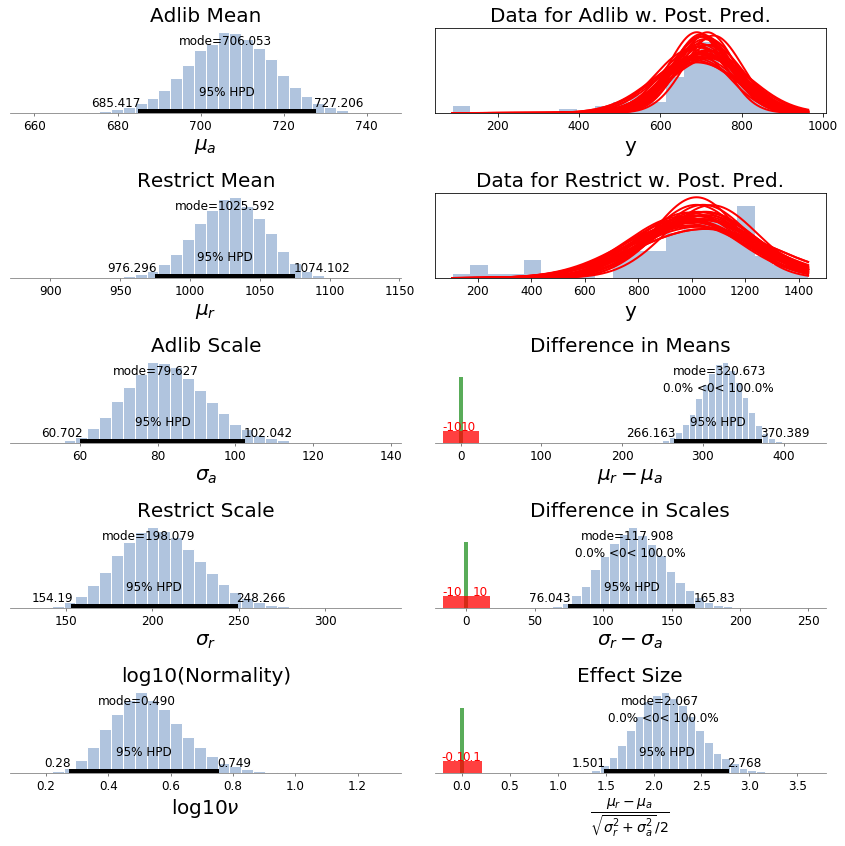

In [19]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_rats['mu'][:,0], ax=ax0, color=color, point_estimate = 'mode')
ax0.set_title('Adlib Mean')
ax0.set_xlabel(r'$\mu_a$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_rats['mu'][:,1], ax=ax1, color=color, point_estimate = 'mode')
ax1.set_title('Restrict Mean')
ax1.set_xlabel(r'$\mu_r$')

ax2 = plt.subplot(gs[2,0])
pm.plot_posterior(trace_rats['sigma'][:,0], ax=ax2, color=color, point_estimate = 'mode')
ax2.set_title('Adlib Scale')
ax2.set_xlabel(r'$\sigma_a$')

ax3 = plt.subplot(gs[3,0])
pm.plot_posterior(trace_rats['sigma'][:,1], ax=ax3, color=color, point_estimate = 'mode')
ax3.set_title('Restrict Scale')
ax3.set_xlabel(r'$\sigma_r$')

ax4 = plt.subplot(gs[4,0])
pm.plot_posterior(np.log10(trace_rats['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

curve_samples = 30
adlib = rats[rats.Group == 'Adlib'].DaysLive
restrict = rats[rats.Group == 'Restrict'].DaysLive
indexes = np.random.choice(range(len(trace_rats)), replace = False, size = curve_samples)

ax5 = plt.subplot(gs[0,1])
ax5.hist(adlib, bins=20, density = True, color = color)
x = np.linspace(min(adlib), max(adlib),1000)
for step in indexes:
    ax5.plot(x, norm.pdf(x, trace_rats['mu'][:,0][step], trace_rats['sigma'][:,0][step]), c='r')
ax5.set_title('Data for Adlib w. Post. Pred.')
ax5.set_xlabel('y')
ax5.yaxis.set_visible(False)

ax6 = plt.subplot(gs[1,1])
ax6.hist(restrict, bins=20, density = True, color = color)
x = np.linspace(min(restrict), max(restrict),1000)
for step in indexes:
    ax6.plot(x, norm.pdf(x, trace_rats['mu'][:,1][step], trace_rats['sigma'][:,1][step]), c='r')
ax6.set_title('Data for Restrict w. Post. Pred.')
ax6.set_xlabel('y')
ax6.yaxis.set_visible(False)

ax7 = plt.subplot(gs[2,1])
pm.plot_posterior(trace_rats['mu'][:,1] - trace_rats['mu'][:,0], ax=ax7, color=color, ref_val = 0, rope=[-10,10], point_estimate = 'mode')
ax7.set_title('Difference in Means')
ax7.set_xlabel(r'$\mu_r - \mu_a$')

ax8 = plt.subplot(gs[3,1])
pm.plot_posterior(trace_rats['sigma'][:,1] - trace_rats['sigma'][:,0], ax=ax8, color=color, ref_val = 0, rope=[-10,10], point_estimate = 'mode')
ax8.set_title('Difference in Scales')
ax8.set_xlabel(r'$\sigma_r - \sigma_a$')

ax9 = plt.subplot(gs[4,1])
num = trace_rats['mu'][:,1] - trace_rats['mu'][:,0]
denom = ((trace_rats['sigma'][:,1]**2 + trace_rats['sigma'][:,0]**2)/2)**0.5
pm.plot_posterior(num/denom, ax=ax9, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax9.set_title('Effect Size')
ax9.set_xlabel(r'$\frac{\mu_r-\mu_a}{\sqrt{\sigma_r^2 + \sigma_a^2}/2}$')

plt.tight_layout()
plt.show()

B. The data within each group appear to be skewed to the left. That is, within each group, there are many rats that died relatively young, but there are fewer outliers on the high end. We could try to implement a skewed noise distribution, or we could try to transform the data so they are approximately symmetric within each group. We will try the latter approach here. To get rid of leftward skew, we need a transformation that expands the rightward values. We will try squaring the data. Does the value of the normality parameter suggest that the data have outliers relative to a normal distribution on the days-squared scale? Is the posterior effect size on the days-squared scale much different than the posterior effect size on the days scale from the previous part?

Answer:

The effect size is large but not as large as with the regular data. The differences of the mean and standard deviation show that a difference exists between the group. The normality parameter is very large, thus the tails of the distribution are smaller than with the original data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


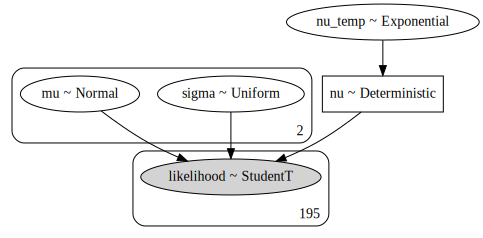

In [38]:
rats = pd.read_csv('data/RatLives.csv', dtype={'Group':'category'})
rats['DaysLive'] = rats['DaysLive']**2
trial_type = rats.Group.cat.codes.values
trials = rats.Group.cat.categories
num_of_trials = len(trials)
observed = rats.DaysLive

mean = np.mean(rats.DaysLive)
sd = np.std(rats.DaysLive)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mu = mean, sd = sd, shape = num_of_trials)
    sigma = pm.Uniform('sigma', lower = sd/1000, upper = sd*1000, shape = num_of_trials)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
    likelihood = pm.StudentT('likelihood', mu = mu[trial_type], sd=sigma[trial_type], nu = nu, observed=observed)
    
    trace_rats_sq = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})

pm.model_to_graphviz(model)


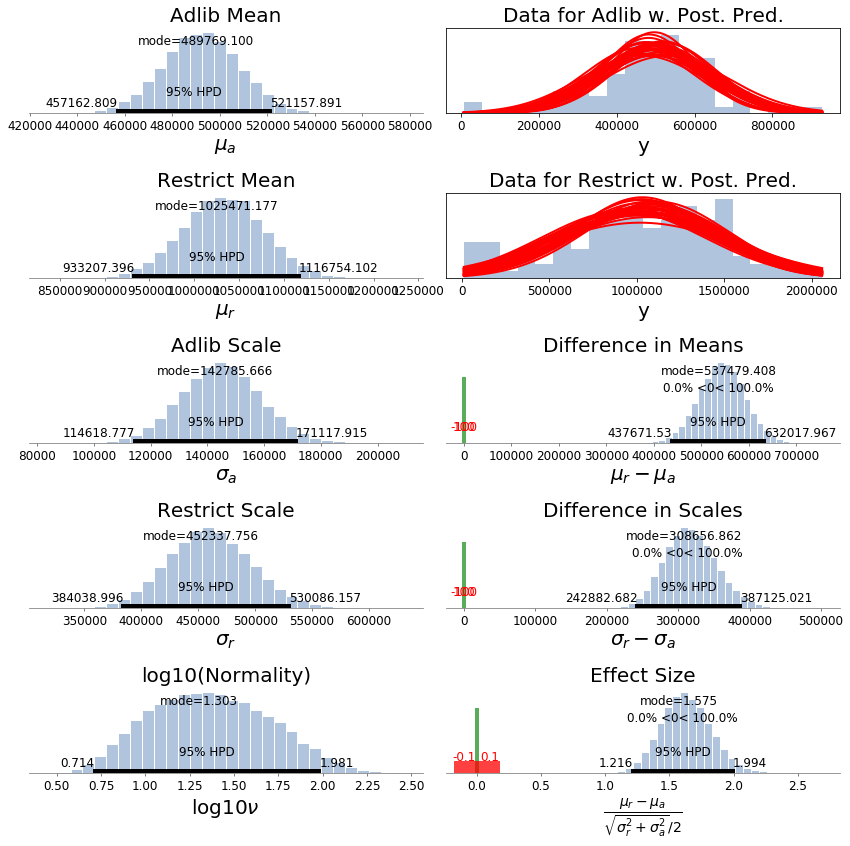

In [21]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_rats_sq['mu'][:,0], ax=ax0, color=color, point_estimate = 'mode')
ax0.set_title('Adlib Mean')
ax0.set_xlabel(r'$\mu_a$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_rats_sq['mu'][:,1], ax=ax1, color=color, point_estimate = 'mode')
ax1.set_title('Restrict Mean')
ax1.set_xlabel(r'$\mu_r$')

ax2 = plt.subplot(gs[2,0])
pm.plot_posterior(trace_rats_sq['sigma'][:,0], ax=ax2, color=color, point_estimate = 'mode')
ax2.set_title('Adlib Scale')
ax2.set_xlabel(r'$\sigma_a$')

ax3 = plt.subplot(gs[3,0])
pm.plot_posterior(trace_rats_sq['sigma'][:,1], ax=ax3, color=color, point_estimate = 'mode')
ax3.set_title('Restrict Scale')
ax3.set_xlabel(r'$\sigma_r$')

ax4 = plt.subplot(gs[4,0])
pm.plot_posterior(np.log10(trace_rats_sq['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

curve_samples = 30
adlib = rats[rats.Group == 'Adlib'].DaysLive
restrict = rats[rats.Group == 'Restrict'].DaysLive
indexes = np.random.choice(range(len(trace_rats_sq)), replace = False, size = curve_samples)

ax5 = plt.subplot(gs[0,1])
ax5.hist(adlib, bins=20, density = True, color = color)
x = np.linspace(min(adlib), max(adlib),1000)
for step in indexes:
    ax5.plot(x, norm.pdf(x, trace_rats_sq['mu'][:,0][step], trace_rats_sq['sigma'][:,0][step]), c='r')
ax5.set_title('Data for Adlib w. Post. Pred.')
ax5.set_xlabel('y')
ax5.yaxis.set_visible(False)

ax6 = plt.subplot(gs[1,1])
ax6.hist(restrict, bins=20, density = True, color = color)
x = np.linspace(min(restrict), max(restrict),1000)
for step in indexes:
    ax6.plot(x, norm.pdf(x, trace_rats_sq['mu'][:,1][step], trace_rats_sq['sigma'][:,1][step]), c='r')
ax6.set_title('Data for Restrict w. Post. Pred.')
ax6.set_xlabel('y')
ax6.yaxis.set_visible(False)

ax7 = plt.subplot(gs[2,1])
pm.plot_posterior(trace_rats_sq['mu'][:,1] - trace_rats_sq['mu'][:,0], ax=ax7, color=color, ref_val = 0, rope=[-100,100], point_estimate = 'mode')
ax7.set_title('Difference in Means')
ax7.set_xlabel(r'$\mu_r - \mu_a$')

ax8 = plt.subplot(gs[3,1])
pm.plot_posterior(trace_rats_sq['sigma'][:,1] - trace_rats_sq['sigma'][:,0], ax=ax8, color=color, ref_val = 0, rope=[-100,100], point_estimate = 'mode')
ax8.set_title('Difference in Scales')
ax8.set_xlabel(r'$\sigma_r - \sigma_a$')

ax9 = plt.subplot(gs[4,1])
num = trace_rats_sq['mu'][:,1] - trace_rats_sq['mu'][:,0]
denom = ((trace_rats_sq['sigma'][:,1]**2 + trace_rats_sq['sigma'][:,0]**2)/2)**0.5
pm.plot_posterior(num/denom, ax=ax9, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax9.set_title('Effect Size')
ax9.set_xlabel(r'$\frac{\mu_r-\mu_a}{\sqrt{\sigma_r^2 + \sigma_a^2}/2}$')

plt.tight_layout()
plt.show()

## 16.3

B. Modify the script to sample from the prior. 


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_temp, sigma, mu]
INFO:pymc3:NUTS: [nu_temp, sigma, mu]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


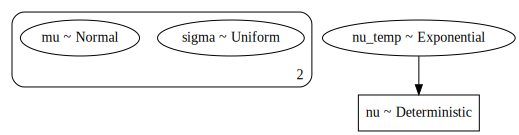

In [131]:
IQ = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
trial_type = IQ.Group.cat.codes.values
trials = IQ.Group.cat.categories
num_of_trials = len(trials)
observed = IQ.Score

mean = np.mean(IQ.Score)
sd = np.std(IQ.Score)

with pm.Model() as model:
    
    ## priors
    mu = pm.Normal('mu', mu = mean, sd = sd, shape = num_of_trials)
    sigma = pm.Uniform('sigma', lower = sd/1000, upper = sd*1000, shape = num_of_trials)
    nu_temp = pm.Exponential('nu_temp', lam=1/29)
    nu = pm.Deterministic('nu', 1 + nu_temp)
    
    # Likelihood function
#     likelihood = pm.StudentT('likelihood', mu = mu[trial_type], sd=sigma[trial_type], nu = nu, observed=total)
    
    trace_prior = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = False ,nuts_kwargs={'target_accept': 0.90})

pm.model_to_graphviz(model)


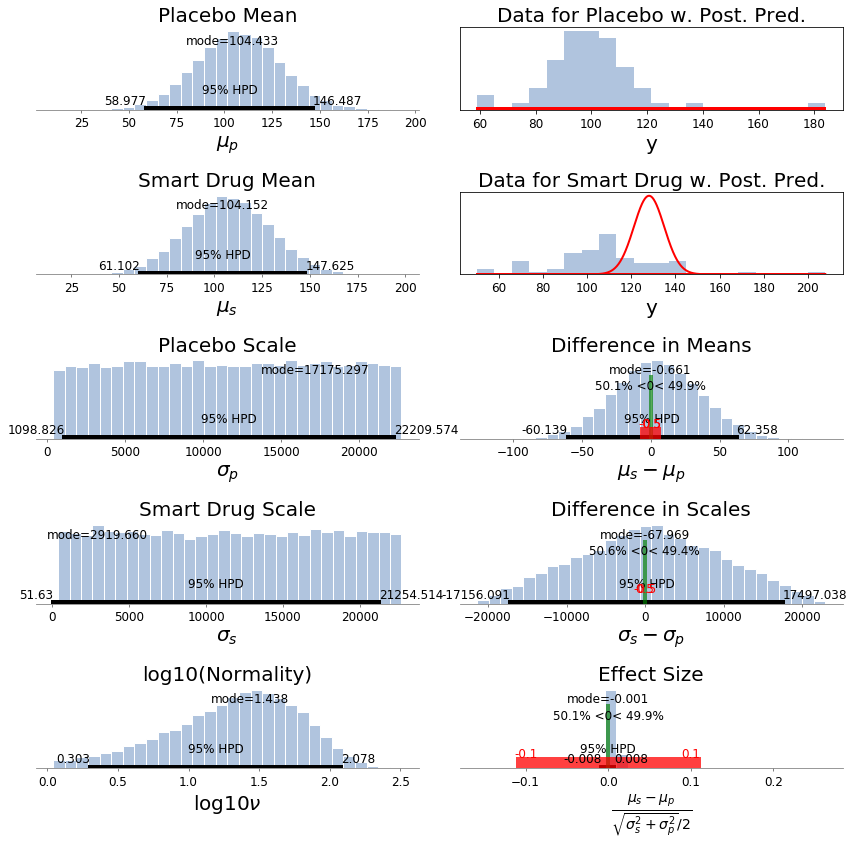

In [132]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 2)

ax0 = plt.subplot(gs[0,0])
pm.plot_posterior(trace_prior['mu'][:,0], ax=ax0, color=color, point_estimate = 'mode')
ax0.set_title('Placebo Mean')
ax0.set_xlabel(r'$\mu_p$')

ax1 = plt.subplot(gs[1,0])
pm.plot_posterior(trace_prior['mu'][:,1], ax=ax1, color=color, point_estimate = 'mode')
ax1.set_title('Smart Drug Mean')
ax1.set_xlabel(r'$\mu_s$')

ax2 = plt.subplot(gs[2,0])
pm.plot_posterior(trace_prior['sigma'][:,0], ax=ax2, color=color, point_estimate = 'mode')
ax2.set_title('Placebo Scale')
ax2.set_xlabel(r'$\sigma_p$')

ax3 = plt.subplot(gs[3,0])
pm.plot_posterior(trace_prior['sigma'][:,1], ax=ax3, color=color, point_estimate = 'mode')
ax3.set_title('Smart Drug Scale')
ax3.set_xlabel(r'$\sigma_s$')

ax4 = plt.subplot(gs[4,0])
pm.plot_posterior(np.log10(trace_prior['nu']), ax=ax4, color=color, point_estimate = 'mode')
ax4.set_title('log10(Normality)')
ax4.set_xlabel(r'$\log10\nu$')

curve_samples = 30
placebo = IQ[IQ.Group == 'Placebo'].Score
drug = IQ[IQ.Group == 'Smart Drug'].Score
indexes = np.random.choice(range(len(trace_prior)), replace = False, size = curve_samples)

ax5 = plt.subplot(gs[0,1])
ax5.hist(placebo, bins=20, density = True, color = color)
x = np.linspace(min(placebo), max(placebo),1000)
for step in indexes:
    ax5.plot(x, norm.pdf(x, trace_prior['mu'][:,0][step], trace_prior['sigma'][:,0][step]), c='r')
ax5.set_title('Data for Placebo w. Post. Pred.')
ax5.set_xlabel('y')
ax5.yaxis.set_visible(False)

ax6 = plt.subplot(gs[1,1])
ax6.hist(drug, bins=20, density = True, color = color)
x = np.linspace(min(drug), max(drug),1000)
for step in indexes:
    ax6.plot(x, norm.pdf(x, trace_prior['mu'][:,1][step], trace_prior['sigma'][:,1][step]), c='r')
ax6.set_title('Data for Smart Drug w. Post. Pred.')
ax6.set_xlabel('y')
ax6.yaxis.set_visible(False)

ax7 = plt.subplot(gs[2,1])
pm.plot_posterior(trace_prior['mu'][:,1] - trace_prior['mu'][:,0], ax=ax7, color=color, ref_val = 0, rope=[-0.5,0.5], point_estimate = 'mode')
ax7.set_title('Difference in Means')
ax7.set_xlabel(r'$\mu_s - \mu_p$')

ax8 = plt.subplot(gs[3,1])
pm.plot_posterior(trace_prior['sigma'][:,1] - trace_prior['sigma'][:,0], ax=ax8, color=color, ref_val = 0, rope=[-0.5,0.5], point_estimate = 'mode')
ax8.set_title('Difference in Scales')
ax8.set_xlabel(r'$\sigma_s - \sigma_p$')

ax9 = plt.subplot(gs[4,1])
num = trace_prior['mu'][:,1] - trace_prior['mu'][:,0]
denom = ((trace_prior['sigma'][:,1]**2 + trace_prior['sigma'][:,0]**2)/2)**0.5
pm.plot_posterior(num/denom, ax=ax9, color=color, ref_val = 0, rope=[-0.1,0.1], point_estimate = 'mode')
ax9.set_title('Effect Size')
ax9.set_xlabel(r'$\frac{\mu_s-\mu_p}{\sqrt{\sigma_s^2 + \sigma_p^2}/2}$')

plt.tight_layout()
plt.show()

C. From the previous two parts, is the prior on the effect size and differences suitably “noncommittal”? Briefly discuss.

The priors on those parts are suitably noncommittal because they have a very broad range centered around zero.